In [ ]:
# https://github.com/dphi-official/Imbalanced_classes/blob/master/Dphi_demo_realtime.ipynb (fraud data)
# https://github.com/dphi-official/Machine_Learning_Bootcamp/blob/master/Data_Preparation_101/Data_Preparation_101.ipynb (titanic)
# https://drive.google.com/file/d/1DmEx0oCbwr3ZfuHBMrnm--J5QoMyYvRr/view (ppt)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
sns.set()

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Imbalanced_classes/master/fraud_data.csv")
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2994681,0,242834,25.000,H,9803,583.0,150.0,visa,226.0,credit,269.0,87.0,NaN,NaN,yahoo.com,NaN,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7.791666,0.791666,...,0.0,82050.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,NaN,529.0,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10.12,firefox 56.0,24.0,1920x1080,match_status:2,T,F,T,T,desktop,rv:56.0
1,3557242,0,15123000,117.000,W,7919,194.0,150.0,mastercard,166.0,debit,181.0,87.0,483.0,NaN,gmail.com,NaN,1,4,0,0,0,1,0,0,3,0,3,0,4,1,63.0,35.0,1.0,4.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3327470,0,8378575,73.773,C,12778,500.0,185.0,mastercard,224.0,credit,284.0,60.0,NaN,NaN,hotmail.com,hotmail.com,1,3,0,1,0,1,1,0,0,0,2,2,3,1,54.0,54.0,35.0,54.0,35.0,54.0,35.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3118781,0,2607840,400.000,R,12316,548.0,150.0,visa,195.0,credit,441.0,87.0,NaN,371.0,anonymous.com,anonymous.com,1,1,0,1,0,1,0,1,0,1,1,0,1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.0,183599.0,NaN,NaN,6.0,-11.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,15.0,352.0,280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 10.3.3,mobile safari generic,32.0,1136x640,match_status:2,T,F,T,F,mobile,iOS Device
4,3459772,0,12226544,31.950,W,9002,453.0,150.0,visa,226.0,debit,264.0,87.0,10.0,NaN,yahoo.com,NaN,3,3,0,0,3,4,0,0,3,0,2,0,33,3,54.0,54.0,15.0,405.0,32.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Check Fraud and not Fraud Data

In [ ]:
#check the fraud 
df.isFraud.value_counts()

0    57049
1     2005
Name: isFraud, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59054 entries, 0 to 59053
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(385), int64(18), object(31)
memory usage: 195.5+ MB


### Check Missing Value

In [ ]:
df.isna().sum()

TransactionID         0
isFraud               0
TransactionDT         0
TransactionAmt        0
ProductCD             0
                  ...  
id_36             44849
id_37             44849
id_38             44849
DeviceType        44869
DeviceInfo        47133
Length: 434, dtype: int64

### Eliminate automatically variables with more then 20% missingness

Check the feature that has missing data

In [ ]:
missing_columns = df.columns[df.isnull().mean()>0]
missing_columns

Index(['card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
       'dist2', 'P_emaildomain',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=414)

In [ ]:
without_missing_columns = df.columns[df.isnull().mean()==0]
without_missing_columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14'],
      dtype='object')

In [ ]:
df.notnull().sum()/df.shape[0]*100

TransactionID     100.000000
isFraud           100.000000
TransactionDT     100.000000
TransactionAmt    100.000000
ProductCD         100.000000
                     ...    
id_36              24.054255
id_37              24.054255
id_38              24.054255
DeviceType         24.020388
DeviceInfo         20.186609
Length: 434, dtype: float64

In [ ]:
df.card2.isnull().mean()

0.015494293358620924

Filter the data where is missing value < 20%

In [ ]:
df_used = df[df.columns[df.isnull().mean()<0.2]]
df_used.drop("isFraud",axis=1, inplace=True)
df_used.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(59054, 181)

In [ ]:
df_used.columns

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=181)

### Filling missing value in numerical and categorical data

filling with mean in numerical data

In [ ]:
#get all feature with number datatype
number_columns = df_used.select_dtypes(include=np.number).columns
number_columns

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2',
       'card3', 'card5', 'addr1', 'addr2', 'C1',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=177)

In [ ]:
#fillna, mean
df_used.loc[:, number_columns] = df_used.loc[:, number_columns].fillna(df_used.loc[:, number_columns].mean())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


filling with mode in categorical data

In [ ]:
cat_columns = list(set(df_used.columns) - set(number_columns))
cat_columns

['card4', 'card6', 'P_emaildomain', 'ProductCD']

In [ ]:
#fillna, mode
df_used.loc[:, cat_columns] = df_used.loc[:, cat_columns].fillna(df_used.loc[:, cat_columns].mode().iloc[0])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


Check the missing data

In [ ]:
df_used.isnull().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
                 ..
V317              0
V318              0
V319              0
V320              0
V321              0
Length: 181, dtype: int64

In [ ]:
df_used.columns[df_used.isnull().mean() > 0] 

Index([], dtype='object')

In [ ]:
df_used

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2994681,242834,25.000,H,9803,583.0,150.0,visa,226.0,credit,269.0,87.0,yahoo.com,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0.0,124.267325,163.966616,0.55965,0.597624,0.999398,0.124619,0.125551,0.137374,0.13883,0.814731,0.845542,0.133239,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,3557242,15123000,117.000,W,7919,194.0,150.0,mastercard,166.0,debit,181.0,87.0,gmail.com,1,4,0,0,0,1,0,0,3,0,3,0,4,1,63.0,4.000000,4.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,...,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,5.0,5.0,2.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,288.000000,1941.000000,1941.000000,0.000000,234.000000,0.000000,234.000000,0.000000,225.500000,0.000000,288.000000,1707.000000,1707.000000,0.0,0.0,0.0
2,3327470,8378575,73.773,C,12778,500.0,185.0,mastercard,224.0,credit,284.0,60.0,hotmail.com,1,3,0,1,0,1,1,0,0,0,2,2,3,1,54.0,0.000000,54.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.772797,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,3118781,2607840,400.000,R,12316,548.0,150.0,visa,195.0,credit,441.0,87.0,anonymous.com,1,1,0,1,0,1,0,1,0,1,1,0,1,1,0.0,124.267325,163.966616,0.55965,0.597624,0.999398,0.124619,0.125551,0.137374,0.13883,0.814731,0.845542,0.133239,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,3459772,12226544,31.950,W,9002,453.0,150.0,visa,226.0,debit,264.0,87.0,yahoo.com,3,3,0,0,3,4,0,0,3,0,2,0,33,3,54.0,71.000000,620.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,35.950001,0.000000,0.000000,35.950001,0.000000,0.000000,0.000000,99.900002,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59049,3549150,14898396,335.000,W,2616,327.0,150.0,discover,102.0,credit,325.0,87.0,hotmail.com,3,1,0,0,0,1,0,0,2,0,1,0,3,3,0.0,236.000000,236.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
59050,3497600,13371647,20.950,W,3277,111.0,150.0,visa,226.0,debit,231.0,87.0,gmail.com,118,96,0,0,83,79,0,0,72,0,82,0,473,91,17.0,631.000000,631.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,...,1.0,1.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,138.850006,47.950001,0.000000,138.850006,0.000000,47.950001,47.950001,138.850006,47.950001,0.000000,0.000000,0.000000,0.0,0.0,

### Label Encoding and One Hot Encoding

In [ ]:
df_used = pd.get_dummies(df_used, prefix='_', drop_first=True)
df_used.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,...,__hotmail.com,__hotmail.de,__hotmail.es,__hotmail.fr,__icloud.com,__juno.com,__live.com,__live.com.mx,__live.fr,__mac.com,__mail.com,__me.com,__msn.com,__netzero.com,__netzero.net,__optonline.net,__outlook.com,__outlook.es,__prodigy.net.mx,__protonmail.com,__ptd.net,__q.com,__roadrunner.com,__rocketmail.com,__sbcglobal.net,__sc.rr.com,__servicios-ta.com,__suddenlink.net,__twc.com,__verizon.net,__web.de,__windstream.net,__yahoo.co.jp,__yahoo.co.uk,__yahoo.com,__yahoo.com.mx,__yahoo.de,__yahoo.es,__yahoo.fr,__ymail.com
0,2994681,242834,25.000,9803,583.0,150.0,226.0,269.0,87.0,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0.0,124.267325,163.966616,0.55965,0.597624,0.999398,0.124619,0.125551,0.137374,0.13883,0.814731,0.845542,0.133239,0.135394,1.035702,1.058825,0.977247,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,3557242,15123000,117.000,7919,194.0,150.0,166.0,181.0,87.0,1,4,0,0,0,1,0,0,3,0,3,0,4,1,63.0,4.000000,4.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3327470,8378575,73.773,12778,500.0,185.0,224.0,284.0,60.0,1,3,0,1,0,1,1,0,0,0,2,2,3,1,54.0,0.000000,54.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3118781,2607840,400.000,12316,548.0,150.0,195.0,441.0,87.0,1,1,0,1,0,1,0,1,0,1,1,0,1,1,0.0,124.267325,163.966616,0.55965,0.597624,0.999398,0.124619,0.125551,0.137374,0.13883,0.814731,0.845542,0.133239,0.135394,1.035702,1.058825,0.977247,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3459772,12226544,31.950,9002,453.0,150.0,226.0,264.0,87.0,3,3,0,0,3,4,0,0,3,0,2,0,33,3,54.0,71.000000,620.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Example using skalern

In [ ]:
people = pd.DataFrame({
  'id' : [1010, 1011, 1012, 1013],
  'study' : ['SMP','SMA', 'S1', 'SMA'],
  'city' : ['Surabaya', 'Malang', 'Surabaya', 'Banyuwangi'],
  'gender' : ['L','L','L','P']
})
people.head()

,id,study,city,gender
0,1010,SMP,Surabaya,L
1,1011,SMA,Malang,L
2,1012,S1,Surabaya,L
3,1013,SMA,Banyuwangi,P


In [ ]:
#Label Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder = LabelEncoder()
people.study = labelencoder.fit_transform(people.study)
# or manual labelling
# people.study = people.study.map({'SMP':2, 'SMA':1, 'S1':0})
people.head()

,id,study,city,gender
0,1010,2,Surabaya,L
1,1011,1,Malang,L
2,1012,0,Surabaya,L
3,1013,1,Banyuwangi,P


In [ ]:
#lOne Hot Encoding
# ohe =  OneHotEncoder(handle_unknown='ignore', )
# ohe_df = pd.DataFrame(ohe.fit_transform(people[['city','gender']]).toarray())
# people = people.join(ohe_df)
#or using pandas
people = pd.get_dummies(people, prefix='_', drop_first=True)
people.head()

,id,study,__Malang,__Surabaya,__P
0,1010,2,0,1,0
1,1011,1,1,0,0
2,1012,0,0,1,0
3,1013,1,0,0,1


### Build First Machine Learning Model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_used, df.isFraud, test_size=0.3, random_state=123)

In [ ]:
parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4,cv=5,scoring = 'roc_auc')
clf.fit(X=x_train, y=y_train)
dt = clf.best_estimator_  #final decision tree!
print (clf.best_score_, clf.best_params_)

0.7653285584501132 {'max_depth': 8}


In [ ]:
y_pred = clf.predict(x_test)

print("Accuracy Scaore: ", accuracy_score(y_pred, y_test)*100)
print()
print("Confusion Matrix:\n ", confusion_matrix(y_pred, y_test))
print()
print("Classification Report: ", classification_report(y_test, y_pred))

Accuracy Scaore:  97.13834170570638

Confusion Matrix:
  [[17026   428]
 [   79   184]]

Classification Report:                precision    recall  f1-score   support

           0       0.98      1.00      0.99     17105
           1       0.70      0.30      0.42       612

    accuracy                           0.97     17717
   macro avg       0.84      0.65      0.70     17717
weighted avg       0.97      0.97      0.97     17717



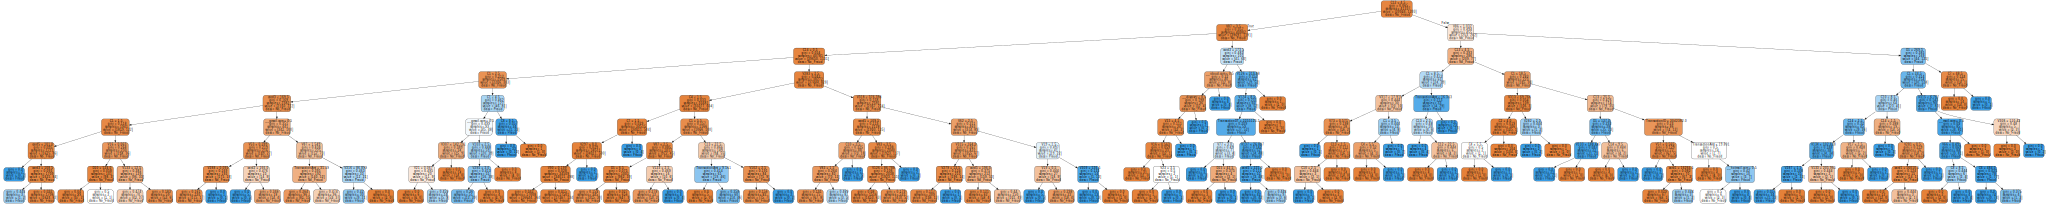

In [ ]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=x_train.columns,  
                                class_names=['No_Fraud','Fraud'],
                                filled=True, rounded=True, 
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

### Feature Transformation

In [ ]:
scale_feature = StandardScaler().fit_transform(df_used)
# scale_feature = MinMaxScaler().fit_transform(df_used)
df_scaled = pd.DataFrame(data = scale_feature)
df_scaled.columns = df_used.columns
df_scaled.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,...,__hotmail.com,__hotmail.de,__hotmail.es,__hotmail.fr,__icloud.com,__juno.com,__live.com,__live.com.mx,__live.fr,__mac.com,__mail.com,__me.com,__msn.com,__netzero.com,__netzero.net,__optonline.net,__outlook.com,__outlook.es,__prodigy.net.mx,__protonmail.com,__ptd.net,__q.com,__roadrunner.com,__rocketmail.com,__sbcglobal.net,__sc.rr.com,__servicios-ta.com,__suddenlink.net,__twc.com,__verizon.net,__web.de,__windstream.net,__yahoo.co.jp,__yahoo.co.uk,__yahoo.com,__yahoo.com.mx,__yahoo.de,__yahoo.es,__yahoo.fr,__ymail.com
0,-1.688548,-1.544958,-0.468203,-0.021940,1.412632,-0.286861,0.653753,-0.225982,0.077832,-0.099186,-0.092969,-0.034155,-0.057671,-0.214317,-0.113785,-0.043835,-0.040593,-0.266499,-0.041472,-0.098587,-0.044784,-0.246816,-0.149534,-0.598309,-8.312926e-17,-1.524289e-16,-2.328077e-16,0.000000,-4.847131e-15,0.000000,0.000000,8.149510e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.454269e-16,...,-0.288310,-0.01164,-0.023646,-0.023285,-0.103676,-0.018406,-0.070735,-0.037289,-0.01164,-0.025707,-0.031891,-0.050125,-0.083819,-0.020987,-0.017461,-0.038411,-0.09194,-0.024698,-0.01594,-0.010888,-0.01164,-0.02058,-0.02058,-0.030532,-0.071337,-0.019305,-0.009202,-0.017461,-0.022166,-0.068774,-0.021387,-0.022918,-0.009202,-0.004115,2.216281,-0.053413,-0.013649,-0.014839,-0.015399,-0.06253
1,1.615662,1.681426,-0.073540,-0.406928,-1.078794,-0.286861,-0.804662,-1.144356,0.077832,-0.099186,-0.071893,-0.034155,-0.057671,-0.214317,-0.113785,-0.043835,-0.052023,-0.085706,-0.052858,-0.075654,-0.044784,-0.222665,-0.149534,-0.198351,-7.035279e-01,-8.579195e-01,9.233902e-01,0.808959,2.627563e-02,-0.399959,-0.396568,-4.033536e-01,-0.399817,0.467841,0.365554,-0.415703,-0.405681,-0.150184,-0.204178,1.322761e-01,...,-0.288310,-0.01164,-0.023646,-0.023285,-0.103676,-0.018406,-0.070735,-0.037289,-0.01164,-0.025707,-0.031891,-0.050125,-0.083819,-0.020987,-0.017461,-0.038411,-0.09194,-0.024698,-0.01594,-0.010888,-0.01164,-0.02058,-0.02058,-0.030532,-0.071337,-0.019305,-0.009202,-0.017461,-0.022166,-0.068774,-0.021387,-0.022918,-0.009202,-0.004115,-0.451206,-0.053413,-0.013649,-0.014839,-0.015399,-0.06253
2,0.266093,0.219070,-0.258976,0.585989,0.881042,2.788641,0.605139,-0.069441,-10.788933,-0.099186,-0.078918,-0.034155,-0.041973,-0.214317,-0.113785,-0.026137,-0.052023,-0.266499,-0.052858,-0.087120,-0.019564,-0.230715,-0.149534,-0.255488,-7.269267e-01,-5.897637e-01,-1.173555e+00,-1.201496,2.627563e-02,2.809494,2.762058,-4.033536e-01,-0.399817,0.467841,0.365554,-0.415703,-0.405681,-0.150184,-0.204178,1.322761e-01,...,3.468494,-0.01164,-0.023646,-0.023285,-0.103676,-0.018406,-0.070735,-0.037289,-0.01164,-0.025707,-0.031891,-0.050125,-0.083819,-0.020987,-0.017461,-0.038411,-0.09194,-0.024698,-0.01594,-0.010888,-0.01164,-0.02058,-0.02058,-0.030532,-0.071337,-0.019305,-0.009202,-0.017461,-0.022166,-0.068774,-0.021387,-0.022918,-0.009202,-0.004115,-0.451206,-0.053413,-0.013649,-0.014839,-0.015399,-0.06253
3,-0.959645,-1.032167,1.140478,0.491581,1.188468,-0.286861,-0.099761,1.569022,0.077832,-0.099186,-0.092969,-0.034155,-0.041973,-0.214317,-0.113785,-0.043835,-0.040593,-0.266499,-0.041472,-0.098587,-0.044784,-0.246816,-0.149534,-0.598309,-8.312926e-17,-1.524289e-16,-2.328077e-16,0.000000,-4.847131e-15,0.000000,0.000000,8.149510e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.454269e-16,...,-0.288310,-0.01164,-0.023646,-0.023285,-0.103676,-0.018406,-0.070735,-0.037289,-0.01164,-0.025707,-0.031891,-0.050125,-0.083819,-0.020987,-0.017461,-0.038411,-0.09194,-0.024698,-0.01594,-0.010888,-0.01164,-0.02058,-0.02058,-0.030532,-0.071337,-0.019305,-0.009202,-0.017461,-0.022166,-0.068774,-0.021387,-0.022918,-0.009202,-0.004115,-0.451206,-0.053413,-0.013649,-0.014839,-0.015399,-0.06253
4,1.043171,1.053404,-0.438389,-0.185621,0.5

### Imbalance Data Handling - Smootie

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


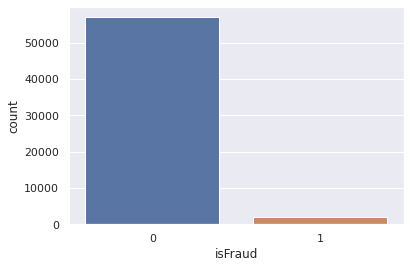

In [ ]:
sns.countplot(df.isFraud)
plt.show()

Oversampling Minority Class

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_scaled, df.isFraud, test_size=0.3, random_state=123)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


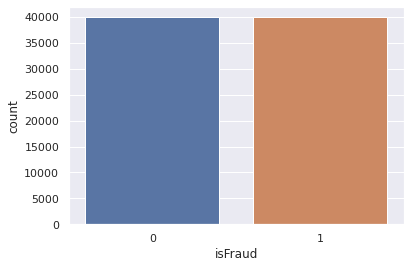

In [ ]:
train_data = pd.concat([x_train, y_train], axis=1)

#split data fraud and not fraud
fraud = train_data[train_data.isFraud == 1]
not_fraud = train_data[train_data.isFraud == 0]

#oversampling minority (not bu this is not the best method)
fraud_upsampled = resample(fraud,
                           replace = True, # Sample with replacement
                           n_samples = len(not_fraud), # Match number in majority class
                           random_state=27)

#concat the data
upsample = pd.concat([not_fraud, fraud_upsampled])

sns.countplot(upsample.isFraud)
plt.show()

Under Sampling Majority Class

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


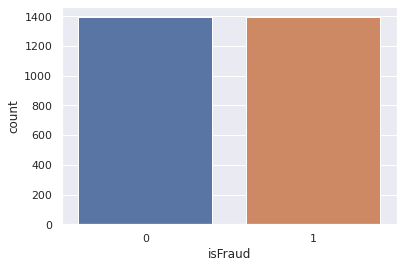

In [ ]:
train_data = pd.concat([x_train, y_train], axis=1)

#split data fraud and not fraud
fraud = train_data[train_data.isFraud == 1]
not_fraud = train_data[train_data.isFraud == 0]

#oversampling minority (not bu this is not the best method)
fraud_downsample = resample(not_fraud,
                           replace = True, # Sample with replacement
                           n_samples = len(fraud), # Match number in majority class
                           random_state=27)

#concat the data
downsample = pd.concat([fraud, fraud_downsample])

sns.countplot(downsample.isFraud)
plt.show()

SMOTE - Oversampling Method

In [ ]:
sm = SMOTE(random_state = 25, sampling_strategy = 1.0)   # again we are eqalizing both the classes

# fit the sampling
x_train, y_train = sm.fit_sample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


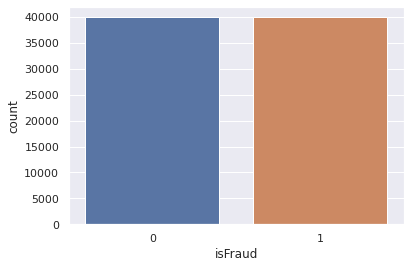

In [ ]:
x1 = pd.DataFrame(x_train, columns=df_used.columns)
x2 = pd.DataFrame(y_train, columns=["isFraud"])
train = pd.concat([x1,x2], axis=1)
sns.countplot(train.isFraud)

Build model after normalize and balancing the data

In [ ]:
#using smote
parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4,cv=5,scoring = 'roc_auc')
clf.fit(X=x_train, y=y_train)
dt = clf.best_estimator_  #final decision tree!
print (clf.best_score_, clf.best_params_)

0.9714477796904044 {'max_depth': 17}


In [ ]:
y_pred = clf.predict(x_test)

print("Accuracy Scaore: ", accuracy_score(y_pred, y_test)*100)
print()
print("Confusion Matrix:\n ", confusion_matrix(y_pred, y_test))
print()
print("Classification Report: ", classification_report(y_test, y_pred))

Accuracy Scaore:  94.33877067223571

Confusion Matrix:
  [[16462   360]
 [  643   252]]

Classification Report:                precision    recall  f1-score   support

           0       0.98      0.96      0.97     17105
           1       0.28      0.41      0.33       612

    accuracy                           0.94     17717
   macro avg       0.63      0.69      0.65     17717
weighted avg       0.95      0.94      0.95     17717

